# CSV File - Categorical and Numerical Columns in Tensorflow

This demo takes a CSV file (can be on object store with a pre-authenticated URL) and uses different encoders to train a sequential model.

See the following demo on categorical columns in tensorflow:
https://www.tensorflow.org/tutorials/structured_data/feature_columns

In [2]:
import pandas as pd
data=pd.read_csv('/root/african_crises.csv')
data.sample(5)




,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
774,56,ZAF,South Africa,1966,0,0.357100,0,0,0.0,3.638361,1,0,0,no_crisis
921,69,ZMB,Zambia,1967,0,0.000710,0,0,0.0,5.012225,1,0,0,no_crisis
763,56,ZAF,South Africa,1955,0,0.357150,0,0,0.0,1.699036,1,0,0,no_crisis
262,15,CIV,Ivory Coast,1994,0,540.000000,0,1,0.0,25.956000,1,1,1,no_crisis
896,63,TUN,Tunisia,2014,0,1.862412,0,0,0.0,4.924000,1,0,0,no_crisis


In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


# Specify the Object Stores pre-authenticated URL
#fp = tf.keras.utils.get_file(fname='/root/african_crises_copy.csv', origin='file:/root/african_crises.csv')

train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')




(677, 'train examples')
(170, 'validation examples')
(212, 'test examples')


In [6]:
# Vocabulary for output columns
#banking_crisis_voc = data['banking_crisis'].unique()


# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('banking_crisis')
  le = LabelEncoder()
  le.fit(labels)
  Y=le.transform(labels)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), Y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 32 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

#display(train_ds)
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of inflation cpi:', feature_batch['inflation_annual_cpi'])
  print('A batch of targets:', label_batch )



('Every feature:', ['case', 'country', 'systemic_crisis', 'exch_usd', 'sovereign_external_debt_default', 'domestic_debt_in_default', 'cc3', 'year', 'currency_crises', 'gdp_weighted_default', 'inflation_annual_cpi', 'inflation_crises', 'independence'])
('A batch of inflation cpi:', <tf.Tensor: id=93, shape=(32,), dtype=float32, numpy=
array([ 14.43033   ,  14.61      ,   2.715967  ,   5.784876  ,
         1.7848036 ,  12.17431   ,   0.84033614,  34.905     ,
        10.551537  , -17.424242  ,  10.673     ,  -2.1524835 ,
         8.229915  ,   3.6166365 ,  17.856     ,   9.210526  ,
         7.9268293 ,   5.329676  ,   7.32      ,   2.584     ,
        -0.658     ,  45.979     ,  12.552797  ,  -2.171162  ,
       -10.874253  ,   1.1946155 ,  15.38672   ,   4.336     ,
         7.617     ,   1.493     ,  13.384     ,  14.236     ],
      dtype=float32)>)
('A batch of targets:', <tf.Tensor: id=98, shape=(32,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,

In [8]:
feature_columns = []

#TODO: independence, inflation crises is category column with identity

# numeric cols
for header in ['inflation_annual_cpi', 'year', 'exch_usd', 'gdp_weighted_default', 'independence', 'inflation_crises', 'domestic_debt_in_default']:
  feature_columns.append(feature_column.numeric_column(header))
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Vocabulary
countries_voc = data['country'].unique()

country = feature_column.categorical_column_with_vocabulary_list(
      'country', countries_voc)
country_one_hot = feature_column.indicator_column(country)
feature_columns.append(country_one_hot)
display(feature_columns)




[NumericColumn(key='inflation_annual_cpi', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='year', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='exch_usd', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='gdp_weighted_default', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='independence', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='inflation_crises', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='domestic_debt_in_default', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='country', vocabulary_list=('Algeria', 'Angola', 'Central African Republic', 'Ivory Coast', 'Egypt', 'Kenya', 'Mauritius', 'Morocco', 'Nigeria', 'South Africa', 'Tuni

In [14]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)


Epoch 1/5
22/22 [==============================] - 1s 44ms/step - loss: 15.9676 - accuracy: 0.8316 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
22/22 [==============================] - 0s 6ms/step - loss: 4.6751 - accuracy: 0.8479 - val_loss: 2.3237 - val_accuracy: 0.8941
Epoch 3/5
22/22 [==============================] - 0s 6ms/step - loss: 1.4684 - accuracy: 0.8922 - val_loss: 2.1956 - val_accuracy: 0.1235
Epoch 4/5
22/22 [==============================] - 0s 6ms/step - loss: 3.7978 - accuracy: 0.8405 - val_loss: 0.8420 - val_accuracy: 0.9176
Epoch 5/5
22/22 [==============================] - 0s 6ms/step - loss: 4.1873 - accuracy: 0.8257 - val_loss: 5.4504 - val_accuracy: 0.9176


In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)


<Figure size 432x288 with 0 Axes>

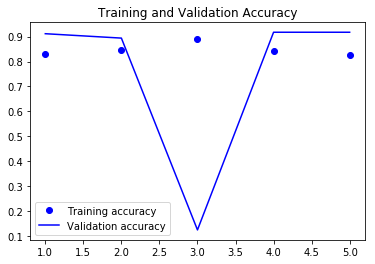

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

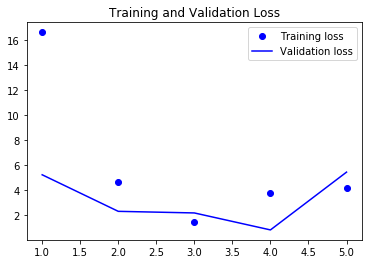

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.figure()